In [1]:
from glob import glob
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#read all file
all_files_path = glob('dataverse_files/*.edf')
print(len(all_files_path))

28


### Understanding the Data:
Let's just take a look at a single sample of data - it should be multi-channel, with voltage readings across time for each of these channels.

In [4]:
all_files_path[0]

'dataverse_files\\h01.edf'

When we load in the file, we set `preload=True` to load the data into memory, increasing efficiency. We then have a `raw` object, which has a variety of methods 

Extracting EDF parameters from C:\Users\plfra\OneDrive - The University of Melbourne\Python Projects\dataverse_files\h01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 231249  =      0.000 ...   924.996 secs...


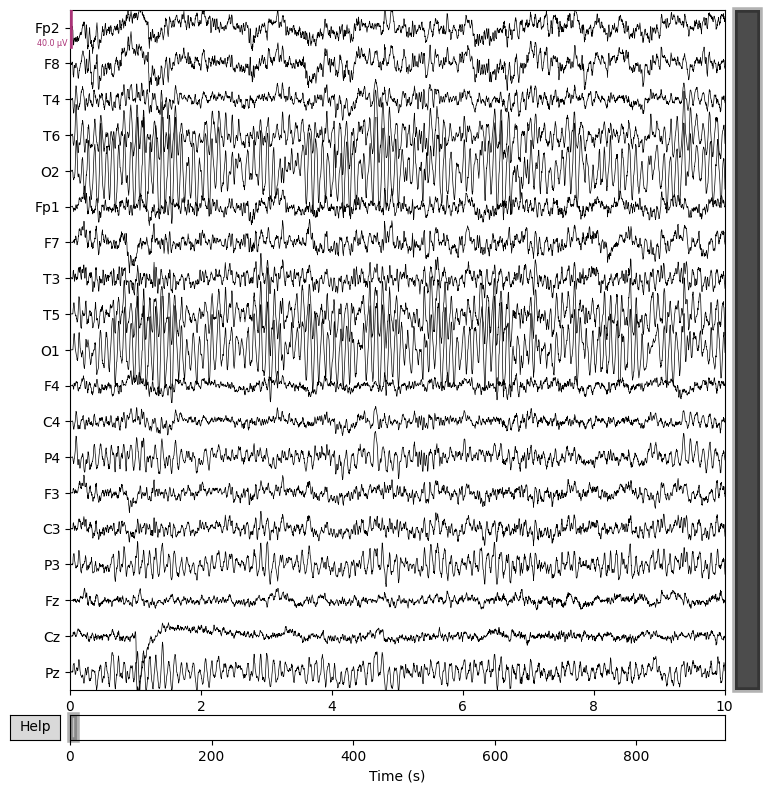

In [7]:
raw = mne.io.read_raw_edf(all_files_path[0], preload=True) 
# Plot the raw data, suppressing automatic output
fig = raw.plot()

# Or, explicitly show the plot if you're using matplotlib in a notebook environment
import matplotlib.pyplot as plt
plt.show()  # Ensures the plot is displayed only once

#### Print some info about the data

In [19]:
print(dir(raw))
print(raw.ch_names)
print(raw.describe)
print(raw._tmin_tmax_to_start_stop)
print(raw.load_data)
raw.info

['__class__', '__contains__', '__del__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_annotations', '_cals', '_check_bad_segment', '_comp', '_cropped_samp', '_data', '_dtype', '_dtype_', '_extra_attributes', '_filenames', '_first_samps', '_first_time', '_get_buffer_size', '_get_channel_positions', '_getitem', '_handle_tmin_tmax', '_init_kwargs', '_last_samps', '_last_time', '_orig_units', '_parse_get_set_params', '_pick_drop_channels', '_pick_projs', '_preload_data', '_projector', '_raw_extras', '_raw_lengths', '_read_comp_grade', '_read_picks', '_read_segment', '_read_segment_file', '_reconstruct_proj', '_repr_html_', '_s

<Info | 8 non-empty values
 bads: []
 ch_names: Fp2, F8, T4, T6, O2, Fp1, F7, T3, T5, O1, F4, C4, P4, F3, C3, ...
 chs: 19 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2003-06-23 16:14:37 UTC
 nchan: 19
 projs: []
 sfreq: 250.0 Hz
 subject_info: 1 item (dict)
>

#### Let's inspect the Data more closely
We find that the raw data is actually a **tuple**. We can access it in *a few different ways.* If we do `raw[0]`, this will give us a tuple with 2 arrays in it, and this is the data for **channel 0** - the first value of the tuple has shape `(1, 231250)`, which should make **perfect sense.** This is the voltages over time, and it's 231250 because this is 250 Hz (recordings per second) * 925 seconds. If we look at the **second tuple**, this is just the 231250 time points, but *split up* - so we can see that it ranges from 0 to 925, in intervals of $\frac{1}{231250}$, which should **also** make sense. We should notice that we cannot go beyond `raw[18]`, otherwise this will raise an *index error*, since there are only 19 channels. <br> <br/>
Now, if we go to `raw[:]` we still get a tuple with 2 arrays, but now the **first array** has shape `(19, 231250)`, indicating that in this context, **each row** is going to represent one of the 19 channels, and each **column** will just be the **time step.** 

#### Important to Check! What units is the data in? Is it Volts (V) or Millivolts (μV) - might need to multiply by 1000 

In [37]:
print(raw[0])
print('-' * 150)
print(raw[18])
print('-' * 150)
print(raw[18][0].shape, raw[18][1].shape)
print('-' * 150)
print(raw[:])
print('-' * 150)
print(raw[:][0], raw[:][0].shape)
print('-' * 150)
print(raw[:][1], raw[:][1].shape)
print('-' * 150)
data, times = raw[:, :] # this allows us to access all the data and all the times 

(array([[2.5e-09, 2.5e-09, 2.5e-09, ..., 2.5e-09, 2.5e-09, 2.5e-09]]), array([0.00000e+00, 4.00000e-03, 8.00000e-03, ..., 9.24988e+02,
       9.24992e+02, 9.24996e+02]))
------------------------------------------------------------------------------------------------------------------------------------------------------
(array([[2.5e-09, 2.5e-09, 2.5e-09, ..., 2.5e-09, 2.5e-09, 2.5e-09]]), array([0.00000e+00, 4.00000e-03, 8.00000e-03, ..., 9.24988e+02,
       9.24992e+02, 9.24996e+02]))
------------------------------------------------------------------------------------------------------------------------------------------------------
(1, 231250) (231250,)
------------------------------------------------------------------------------------------------------------------------------------------------------
(array([[2.5e-09, 2.5e-09, 2.5e-09, ..., 2.5e-09, 2.5e-09, 2.5e-09],
       [2.5e-09, 2.5e-09, 2.5e-09, ..., 2.5e-09, 2.5e-09, 2.5e-09],
       [2.5e-09, 2.5e-09, 2.5e-09, ..., 2.5e-09,

#### Some Quick Visualisations 
Here are some easy matplotlib visualisations of what the untransformed data looks like, for different channels - some times we see that in the top left corner there is a `1e-5` and the axes look much larger - this is just saying we have, for example `8e-5 mV`, which should somewhat approximate the data that we have from channel 0. Generally speaking, the voltage ranges for each of the 19 channels is probably pretty similar - maybe it would be good to do some **summary statistics** later on...

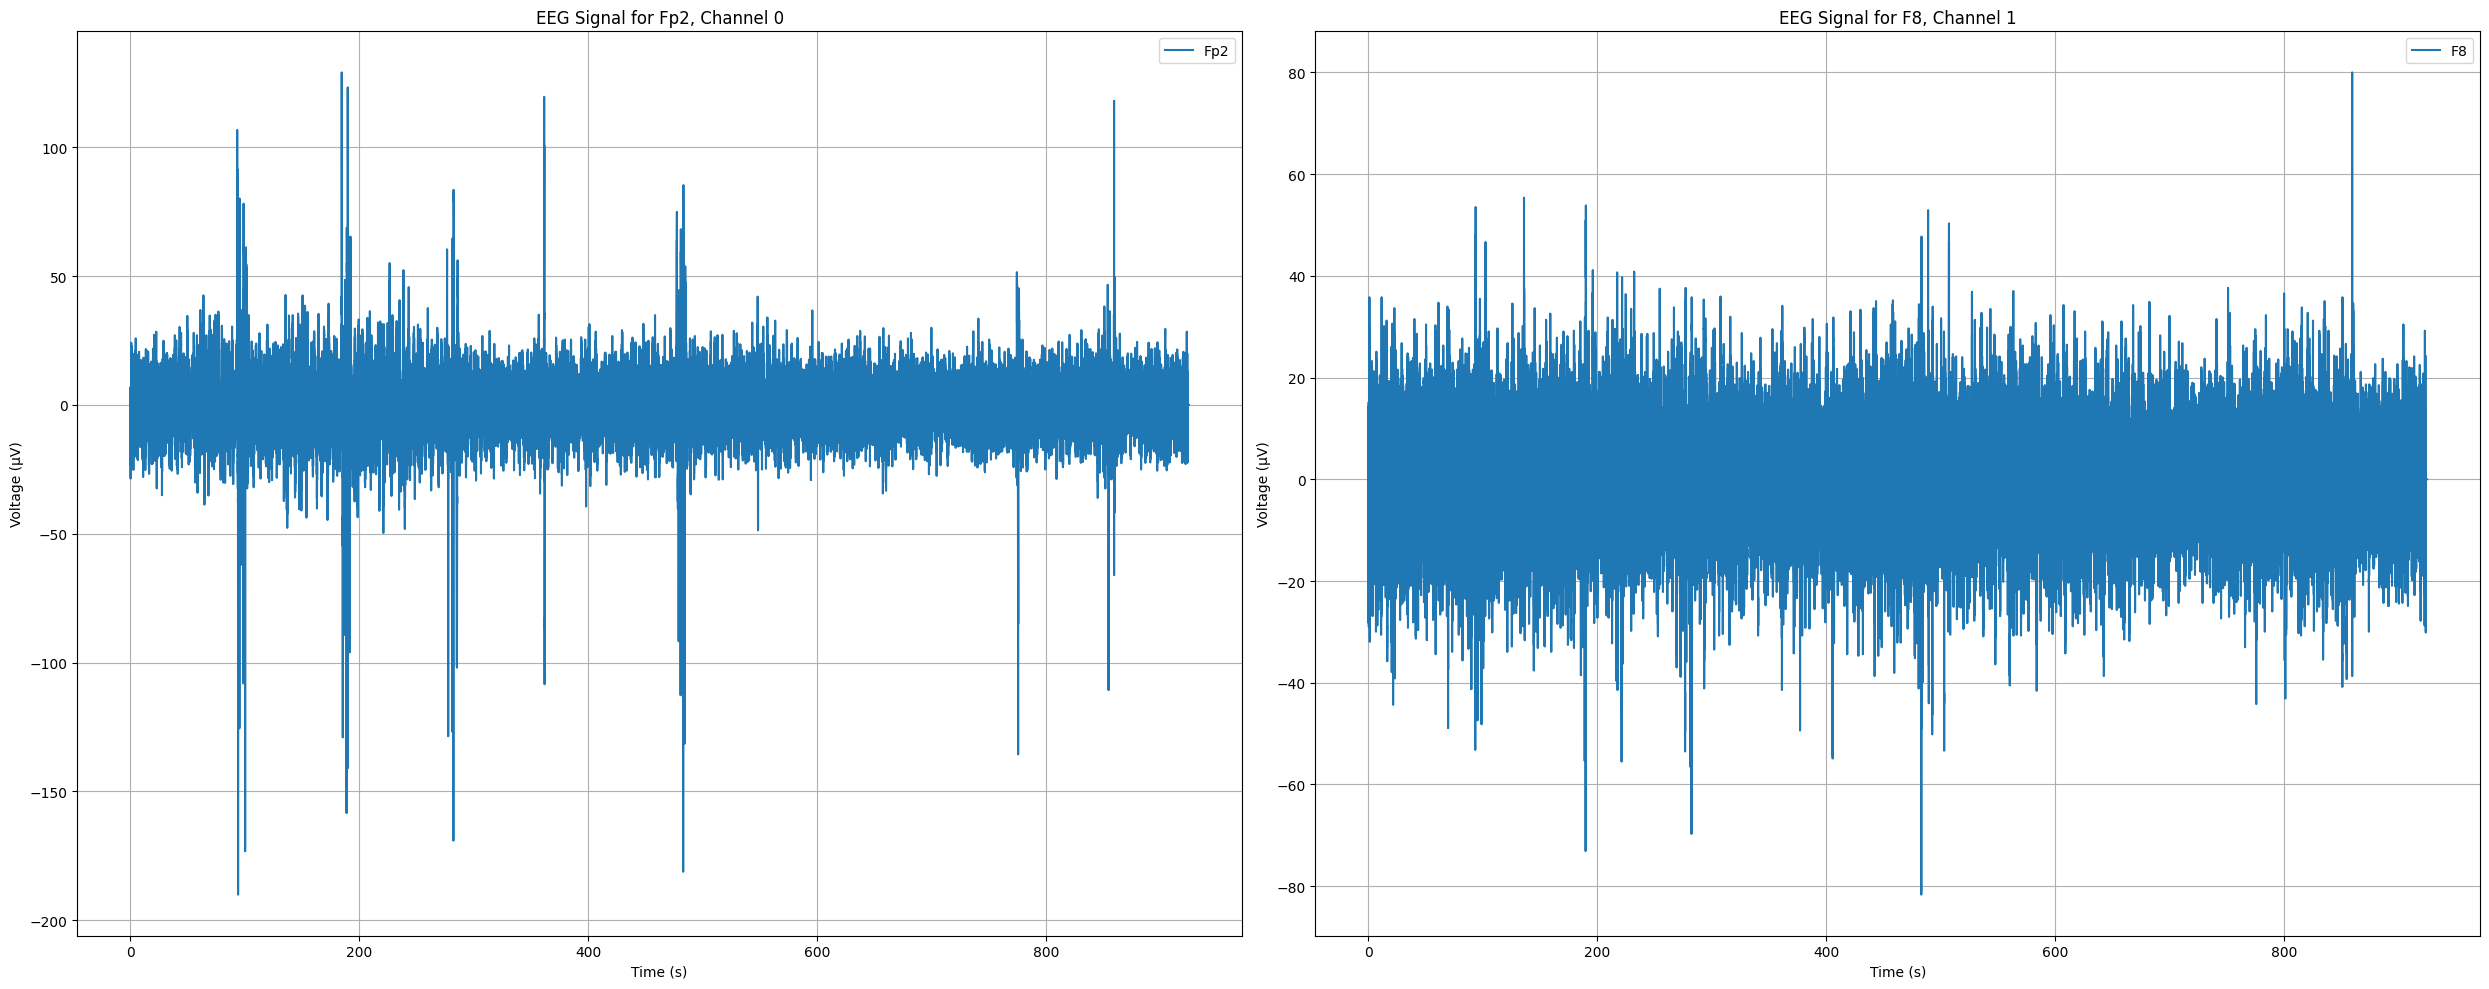

In [63]:
import matplotlib.pyplot as plt

# Create a figure with 2 subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(25, 10))  # Adjust figsize as needed

# Plot the first channel's data over time
channel_index = 0  # Index of the channel you want to plot (first channel)
ax[0].plot(times, 10**6 * data[channel_index, :], label=raw.ch_names[channel_index])
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Voltage (µV)')
ax[0].set_title(f'EEG Signal for {raw.ch_names[channel_index]}, Channel {channel_index}')
ax[0].legend()
ax[0].grid(True)

# Plot the second channel's data over time
channel_index = 1  # Index of the channel you want to plot (second channel)
ax[1].plot(times, 10**6 * data[channel_index, :], label=raw.ch_names[channel_index])
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Voltage (µV)')
ax[1].set_title(f'EEG Signal for {raw.ch_names[channel_index]}, Channel {channel_index}')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()  # Adjusts spacing between subplots
plt.show()


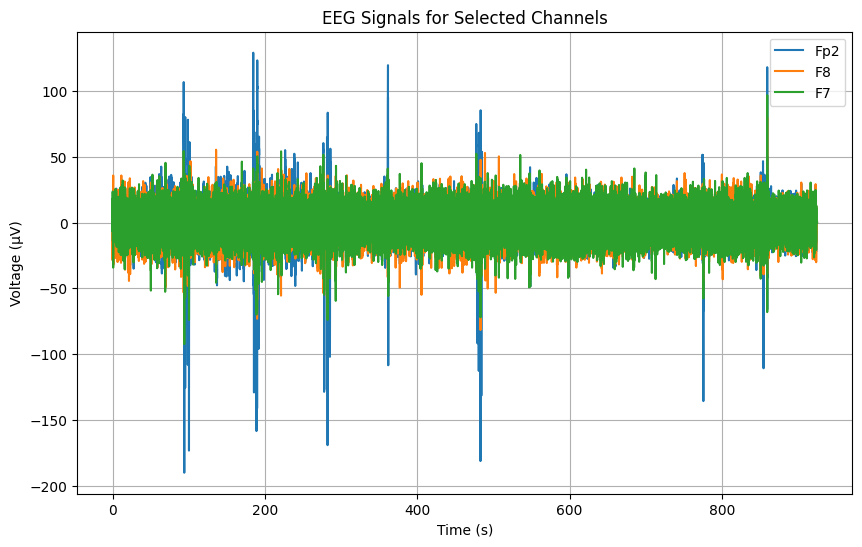

In [64]:
# Select a few channels to plot (e.g., Fp1, Fp2, Fz)
channel_indices = [0, 1, 6]  # Indices of the channels you want to plot

# Plot data for the selected channels
plt.figure(figsize=(10, 6))
for i in channel_indices:
    plt.plot(times, 10**6 * data[i, :], label=raw.ch_names[i])  # Offset for visualization
plt.xlabel('Time (s)')
plt.ylabel('Voltage (µV)')
plt.title('EEG Signals for Selected Channels')
plt.legend()
plt.grid(True)
plt.show()


In [41]:
# A better way to access the data, potentially: 
data, times = raw[:,:]

(231250,)

In [8]:
healthy_file_path=[i for i in all_files_path if  'h' in i.split('\\')[1]]
patient_file_path=[i for i in all_files_path if  's' in i.split('\\')[1]]

In [ ]:
def read_data(file_path):
    datax=mne.io.read_raw_edf(file_path,preload=True)
    datax.set_eeg_reference()
    datax.filter(l_freq=1,h_freq=45)
    epochs=mne.make_fixed_length_epochs(datax,duration=25,overlap=0)
    epochs=epochs.get_data()
    return epochs #trials,channel,length

In [ ]:
data=read_data(healthy_file_path[0])

In [ ]:
data.shape

In [ ]:
control_epochs_array=[read_data(subject) for subject in healthy_file_path]
patients_epochs_array=[read_data(subject) for subject in patient_file_path]

In [ ]:
control_epochs_labels=[len(i)*[0] for i in control_epochs_array]
patients_epochs_labels=[len(i)*[1] for i in patients_epochs_array]
print(len(control_epochs_labels),len(patients_epochs_labels))

In [ ]:
data_list=control_epochs_array+patients_epochs_array
label_list=control_epochs_labels+patients_epochs_labels
print(len(data_list),len(label_list))

In [ ]:
groups_list=[[i]*len(j) for i, j in enumerate(data_list)]

In [ ]:
data_array=np.vstack(data_list)
label_array=np.hstack(label_list)
group_array=np.hstack(groups_list)
print(data_array.shape,label_array.shape,group_array.shape)

In [ ]:
from scipy import stats
def mean(data):
    return np.mean(data,axis=-1)
    
def std(data):
    return np.std(data,axis=-1)

def ptp(data):
    return np.ptp(data,axis=-1)

def var(data):
        return np.var(data,axis=-1)

def minim(data):
      return np.min(data,axis=-1)


def maxim(data):
      return np.max(data,axis=-1)

def argminim(data):
      return np.argmin(data,axis=-1)


def argmaxim(data):
      return np.argmax(data,axis=-1)

def mean_square(data):
      return np.mean(data**2,axis=-1)

def rms(data): #root mean square
      return  np.sqrt(np.mean(data**2,axis=-1))  

def abs_diffs_signal(data):
    return np.sum(np.abs(np.diff(data,axis=-1)),axis=-1)


def skewness(data):
    return stats.skew(data,axis=-1)

def kurtosis(data):
    return stats.kurtosis(data,axis=-1)

def concatenate_features(data):
    return np.concatenate((mean(data),std(data),ptp(data),var(data),minim(data),maxim(data),argminim(data),argmaxim(data),
                          mean_square(data),rms(data),abs_diffs_signal(data),
                          skewness(data),kurtosis(data)),axis=-1)

In [ ]:
from tqdm import tqdm_notebook
features=[]
for data in tqdm_notebook(data_array):
    features.append(concatenate_features(data))
features=np.array(features)
features.shape